<a href="https://colab.research.google.com/github/RohanCheera/FaceTrace/blob/main/models/CyclicGAN_IPAM_200.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import os
import random
import shutil
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Set random seed for reproducibility
random.seed(42)
torch.manual_seed(42)
np.random.seed(42)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:

# Define paths
data_dir = '/content/drive/MyDrive/criminal_faces'  # Placeholder: replace with actual dataset path
project_folder = '/content/drive/MyDrive/FACETest'
train_photo_dir = os.path.join(project_folder, 'train_photos')
train_sketch_dir = os.path.join(project_folder, 'train_sketches')
test_photo_dir = os.path.join(project_folder, 'test_photos')
test_sketch_dir = os.path.join(project_folder, 'test_sketches')

# Create directories
os.makedirs(train_photo_dir, exist_ok=True)
os.makedirs(train_sketch_dir, exist_ok=True)
os.makedirs(test_photo_dir, exist_ok=True)
os.makedirs(test_sketch_dir, exist_ok=True)

# Function to generate synthetic sketches
def generate_sketch(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray, 100, 200)
    noise = np.random.normal(0, 25, gray.shape).astype(np.uint8)
    sketch = cv2.add(gray, noise)
    sketch = cv2.bitwise_or(sketch, edges)
    return sketch


In [28]:

# Prepare dataset
photo_files = [f for f in os.listdir(data_dir) if f.endswith(('.jpg', '.png'))]
if not photo_files:
    raise FileNotFoundError(f"No images found in {data_dir}. Please provide a valid dataset path.")

# Split dataset
random.shuffle(photo_files)
train_size = int(0.8 * len(photo_files))
train_photos = photo_files[:train_size]
test_photos = photo_files[train_size:]

# Process and save images
for photo in train_photos:
    img_path = os.path.join(data_dir, photo)
    img = cv2.imread(img_path)
    if img is None:
        continue
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_sketch = generate_sketch(img_rgb)

    cv2.imwrite(os.path.join(train_photo_dir, photo), cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR))
    cv2.imwrite(os.path.join(train_sketch_dir, photo), img_sketch)

for photo in test_photos:
    img_path = os.path.join(data_dir, photo)
    img = cv2.imread(img_path)
    if img is None:
        continue
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_sketch = generate_sketch(img_rgb)

    cv2.imwrite(os.path.join(test_photo_dir, photo), cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR))
    cv2.imwrite(os.path.join(test_sketch_dir, photo), img_sketch)

print(f"Total images: {len(photo_files)}")
print(f"Train photos: {len(train_photos)}, Train sketches: {len(train_photos)}")
print(f"Test photos: {len(test_photos)}, Test sketches: {len(test_photos)}")
print(f"Data stored at: {project_folder}")


Total images: 790
Train photos: 632, Train sketches: 632
Test photos: 158, Test sketches: 158
Data stored at: /content/drive/MyDrive/FACETest


In [31]:
import os

save_dir = '/content/drive/MyDrive/CUFS_best/models'
os.makedirs(save_dir, exist_ok=True)


In [32]:
#Custom Dataset with augmentation
class CriminalsDataset(Dataset):
    def __init__(self, sketch_dir, photo_dir, transform=None, photo_transform=None):
        self.sketch_dir = sketch_dir
        self.photo_dir = photo_dir
        self.transform = transform
        self.photo_transform = photo_transform
        self.sketches = sorted([f for f in os.listdir(sketch_dir) if f.endswith(('.jpg', '.png'))])
        self.photos = sorted([f for f in os.listdir(photo_dir) if f.endswith(('.jpg', '.png'))])
        if len(self.sketches) != len(self.photos):
            raise ValueError(f"Mismatched sketch-photo pairs: {len(self.sketches)} sketches, {len(self.photos)} photos")

    def __len__(self):
        return len(self.sketches)

    def __getitem__(self, idx):
        sketch_path = os.path.join(self.sketch_dir, self.sketches[idx])
        photo_path = os.path.join(self.photo_dir, self.photos[idx])

        sketch = cv2.imread(sketch_path, cv2.IMREAD_GRAYSCALE)
        photo = cv2.imread(photo_path)
        if sketch is None or photo is None:
            raise ValueError(f"Failed to load image: {sketch_path} or {photo_path}")
        photo = cv2.cvtColor(photo, cv2.COLOR_BGR2RGB)

        sketch = Image.fromarray(sketch)
        photo = Image.fromarray(photo)

        if self.transform:
            sketch = self.transform(sketch)
        if self.photo_transform:
            photo = self.photo_transform(photo)

        return sketch, photo, self.sketches[idx]

# Data transforms
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

photo_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load datasets
train_dataset = CriminalsDataset(
    sketch_dir=train_sketch_dir,
    photo_dir=train_photo_dir,
    transform=transform,
    photo_transform=photo_transform
)
test_dataset = CriminalsDataset(
    sketch_dir=test_sketch_dir,
    photo_dir=test_photo_dir,
    transform=transform,
    photo_transform=photo_transform
)

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0, pin_memory=True)

# Self-Attention Module
class SelfAttention(nn.Module):
    def __init__(self, in_channels):
        super(SelfAttention, self).__init__()
        self.query = nn.Conv2d(in_channels, in_channels // 8, 1)
        self.key = nn.Conv2d(in_channels, in_channels // 8, 1)
        self.value = nn.Conv2d(in_channels, in_channels, 1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        batch, channels, height, width = x.size()
        proj_query = self.query(x).view(batch, -1, height * width).permute(0, 2, 1)
        proj_key = self.key(x).view(batch, -1, height * width)
        energy = torch.bmm(proj_query, proj_key)
        attention = torch.softmax(energy, dim=-1)
        proj_value = self.value(x).view(batch, -1, height * width)
        out = torch.bmm(proj_value, attention.permute(0, 2, 1))
        out = out.view(batch, channels, height, width)
        out = self.gamma * out + x
        return out

# Generator (U-Net with Self-Attention)
class Generator(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Generator, self).__init__()
        self.enc1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2)
        )  # 256x256 -> 128x128
        self.enc2 = nn.Sequential(
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2)
        )  # 128x128 -> 64x64
        self.enc3 = nn.Sequential(
            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2)
        )  # 64x64 -> 32x32
        self.enc4 = nn.Sequential(
            nn.Conv2d(256, 512, 4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2)
        )  # 32x32 -> 16x16
        self.enc5 = nn.Sequential(
            nn.Conv2d(512, 512, 4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2)
        )  # 16x16 -> 8x8
        self.attention = SelfAttention(512)
        self.dec1 = nn.Sequential(
            nn.ConvTranspose2d(512, 512, 4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Dropout(0.3)
        )  # 8x8 -> 16x16
        self.dec2 = nn.Sequential(
            nn.ConvTranspose2d(1024, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout(0.3)
        )  # 16x16 -> 32x32
        self.dec3 = nn.Sequential(
            nn.ConvTranspose2d(512, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(0.3)
        )  # 32x32 -> 64x64
        self.dec4 = nn.Sequential(
            nn.ConvTranspose2d(256, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(0.3)
        )  # 64x64 -> 128x128
        self.dec5 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(0.3)
        )  # 128x128 -> 256x256
        self.dec6 = nn.Sequential(
            nn.Conv2d(64, out_channels, 3, stride=1, padding=1),
            nn.Tanh()
        )  # 256x256 -> 256x256

    def forward(self, x):
        e1 = self.enc1(x)  # [batch, 64, 128, 128]
        e2 = self.enc2(e1)
        e3 = self.enc3(e2)
        e4 = self.enc4(e3)
        e5 = self.enc5(e4)
        e5 = self.attention(e5)
        d1 = self.dec1(e5)
        d2 = self.dec2(torch.cat([d1, e4], dim=1))
        d3 = self.dec3(torch.cat([d2, e3], dim=1))
        d4 = self.dec4(torch.cat([d3, e2], dim=1))
        d5 = self.dec5(torch.cat([d4, e1], dim=1))  # [batch, 64, 256, 256]
        d6 = self.dec6(d5)  # [batch, out_channels, 256, 256]
        return d6

# Discriminator (PatchGAN)
class Discriminator(nn.Module):
    def __init__(self, in_channels):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, 64, 4, stride=2, padding=1),  # 256x256 -> 128x128
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),          # 128x128 -> 64x64
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, stride=2, padding=1),         # 64x64 -> 32x32
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, stride=2, padding=1),         # 32x32 -> 16x16
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, stride=1, padding=1)            # 16x16 -> 16x16
        )

    def forward(self, x):
        return self.model(x)

# IPAM (Identity Preserving Attention Module)
class IPAM(nn.Module):
    def __init__(self):
        super(IPAM, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 64, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

    def forward(self, x):
        return self.feature_extractor(x)

# Loss functions
def adversarial_loss(output, target):
    return nn.BCELoss()(torch.sigmoid(output), target)

def cycle_loss(reconstructed, original):
    return nn.L1Loss()(reconstructed, original)

def identity_loss(fake_features, real_features):
    return nn.L1Loss()(fake_features, real_features)

def pixel_loss(fake, real):
    return nn.L1Loss()(fake, real)

def color_loss(fake, real):
    return nn.MSELoss()(fake, real)

# Initialize models
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
G_sketch_to_photo = Generator(in_channels=1, out_channels=3).to(device)
G_photo_to_sketch = Generator(in_channels=3, out_channels=1).to(device)
D_sketch = Discriminator(in_channels=1).to(device)
D_photo = Discriminator(in_channels=3).to(device)
ipam = IPAM().to(device)

# Optimizers and schedulers (unchanged)
g_optimizer = optim.Adam(
    list(G_sketch_to_photo.parameters()) + list(G_photo_to_sketch.parameters()),
    lr=0.0002, betas=(0.5, 0.999)
)
d_sketch_optimizer = optim.Adam(D_sketch.parameters(), lr=0.0002, betas=(0.5, 0.999))
d_photo_optimizer = optim.Adam(D_photo.parameters(), lr=0.0002, betas=(0.5, 0.999))
ipam_optimizer = optim.Adam(ipam.parameters(), lr=0.0002, betas=(0.5, 0.999))

scheduler_g = optim.lr_scheduler.StepLR(g_optimizer, step_size=50, gamma=0.1)
scheduler_d_sketch = optim.lr_scheduler.StepLR(d_sketch_optimizer, step_size=50, gamma=0.1)
scheduler_d_photo = optim.lr_scheduler.StepLR(d_photo_optimizer, step_size=50, gamma=0.1)
scheduler_ipam = optim.lr_scheduler.StepLR(ipam_optimizer, step_size=50, gamma=0.1)

# Training loop
num_epochs = 200
lambda_cycle = 10.0
lambda_identity = 5.0
lambda_pixel = 5.0
lambda_color = 2.0
losses_g = []
losses_d_sketch = []
losses_d_photo = []

for epoch in range(num_epochs):
    epoch_g_loss = 0.0
    epoch_d_sketch_loss = 0.0
    epoch_d_photo_loss = 0.0
    G_sketch_to_photo.train()
    G_photo_to_sketch.train()
    D_sketch.train()
    D_photo.train()
    ipam.train()

    for i, (sketches, photos, _) in enumerate(train_dataloader):
        sketches = sketches.to(device)
        photos = photos.to(device)

        # Verify input shapes
        if sketches.shape[-2:] != (256, 256) or photos.shape[-2:] != (256, 256):
            raise ValueError(f"Unexpected image size: sketches {sketches.shape}, photos {photos.shape}")

        # Train Discriminators
        d_sketch_optimizer.zero_grad()
        d_photo_optimizer.zero_grad()

        real_sketch_output = D_sketch(sketches)
        real_photo_output = D_photo(photos)
        real_label = torch.ones_like(real_sketch_output).to(device)
        fake_label = torch.zeros_like(real_sketch_output).to(device)

        fake_photos = G_sketch_to_photo(sketches)
        fake_sketches = G_photo_to_sketch(photos)

        # Verify generator output shapes
        if fake_sketches.shape[-2:] != (256, 256):
            raise ValueError(f"Expected fake_sketches 256x256, got {fake_sketches.shape}")
        if fake_photos.shape[-2:] != (256, 256):
            raise ValueError(f"Expected fake_photos 256x256, got {fake_photos.shape}")

        fake_sketch_output = D_sketch(fake_sketches.detach())
        fake_photo_output = D_photo(fake_photos.detach())

        d_sketch_real_loss = adversarial_loss(real_sketch_output, real_label)
        d_photo_real_loss = adversarial_loss(real_photo_output, real_label)
        d_sketch_fake_loss = adversarial_loss(fake_sketch_output, fake_label)
        d_photo_fake_loss = adversarial_loss(fake_photo_output, fake_label)

        d_sketch_loss = (d_sketch_real_loss + d_sketch_fake_loss) / 2
        d_photo_loss = (d_photo_real_loss + d_photo_fake_loss) / 2
        d_sketch_loss.backward()
        d_photo_loss.backward()
        d_sketch_optimizer.step()
        d_photo_optimizer.step()

        # Train Generators
        g_optimizer.zero_grad()
        ipam_optimizer.zero_grad()

        fake_photos = G_sketch_to_photo(sketches)
        fake_sketches = G_photo_to_sketch(photos)
        fake_photo_output = D_photo(fake_photos)
        fake_sketch_output = D_sketch(fake_sketches)

        g_photo_adv_loss = adversarial_loss(fake_photo_output, real_label)
        g_sketch_adv_loss = adversarial_loss(fake_sketch_output, real_label)

        cycle_sketches = G_photo_to_sketch(fake_photos)
        cycle_photos = G_sketch_to_photo(fake_sketches)
        cycle_sketch_loss = cycle_loss(cycle_sketches, sketches) * lambda_cycle
        cycle_photo_loss = cycle_loss(cycle_photos, photos) * lambda_cycle

        ipam_real = ipam(photos)
        ipam_fake = ipam(fake_photos)
        ipam_loss = identity_loss(ipam_fake, ipam_real) * lambda_identity

        pixel_loss_val = pixel_loss(fake_photos, photos) * lambda_pixel
        color_loss_val = color_loss(fake_photos, photos) * lambda_color

        g_loss = g_photo_adv_loss + g_sketch_adv_loss + cycle_sketch_loss + cycle_photo_loss + ipam_loss + pixel_loss_val + color_loss_val
        g_loss.backward()
        torch.nn.utils.clip_grad_norm_(G_sketch_to_photo.parameters(), max_norm=1.0)
        torch.nn.utils.clip_grad_norm_(G_photo_to_sketch.parameters(), max_norm=1.0)
        torch.nn.utils.clip_grad_norm_(ipam.parameters(), max_norm=1.0)
        g_optimizer.step()
        ipam_optimizer.step()

        epoch_g_loss += g_loss.item()
        epoch_d_sketch_loss += d_sketch_loss.item()
        epoch_d_photo_loss += d_photo_loss.item()

        if i % 50 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}] Batch [{i}/{len(train_dataloader)}] '
                  f'D_Sketch Loss: {d_sketch_loss.item():.4f} D_Photo Loss: {d_photo_loss.item():.4f} '
                  f'G Loss: {g_loss.item():.4f}')

    scheduler_g.step()
    scheduler_d_sketch.step()
    scheduler_d_photo.step()
    scheduler_ipam.step()

    losses_g.append(epoch_g_loss / len(train_dataloader))
    losses_d_sketch.append(epoch_d_sketch_loss / len(train_dataloader))
    losses_d_photo.append(epoch_d_photo_loss / len(train_dataloader))

    if (epoch + 1) % 10 == 0:
        torch.save(G_sketch_to_photo.state_dict(), f'{save_dir}/G_sketch_to_photo_epoch_{epoch+1}.pth')
        torch.save(G_photo_to_sketch.state_dict(), f'{save_dir}/G_photo_to_sketch_epoch_{epoch+1}.pth')
        torch.save(D_sketch.state_dict(), f'{save_dir}/D_sketch_epoch_{epoch+1}.pth')
        torch.save(D_photo.state_dict(), f'{save_dir}/D_photo_epoch_{epoch+1}.pth')
        torch.save(ipam.state_dict(), f'{save_dir}/ipam_epoch_{epoch+1}.pth')

# Save final models
torch.save(G_sketch_to_photo.state_dict(), f'{save_dir}/G_sketch_to_photo_best.pth')
torch.save(G_photo_to_sketch.state_dict(), f'{save_dir}/G_photo_to_sketch_best.pth')
torch.save(D_sketch.state_dict(), f'{save_dir}/D_sketch_best.pth')
torch.save(D_photo.state_dict(), f'{save_dir}/D_photo_best.pth')
torch.save(ipam.state_dict(), f'{save_dir}/ipam_best.pth')

print("Training complete. Models saved.")


Epoch [1/200] Batch [0/193] D_Sketch Loss: 0.7046 D_Photo Loss: 0.7113 G Loss: 19.6969
Epoch [1/200] Batch [50/193] D_Sketch Loss: 0.6447 D_Photo Loss: 0.3984 G Loss: 8.4249
Epoch [1/200] Batch [100/193] D_Sketch Loss: 0.5415 D_Photo Loss: 0.3953 G Loss: 8.5139
Epoch [1/200] Batch [150/193] D_Sketch Loss: 0.2956 D_Photo Loss: 0.7045 G Loss: 7.5918
Epoch [2/200] Batch [0/193] D_Sketch Loss: 0.4619 D_Photo Loss: 0.6400 G Loss: 8.1799
Epoch [2/200] Batch [50/193] D_Sketch Loss: 0.6005 D_Photo Loss: 0.7291 G Loss: 8.8820
Epoch [2/200] Batch [100/193] D_Sketch Loss: 0.3942 D_Photo Loss: 0.5738 G Loss: 8.9409
Epoch [2/200] Batch [150/193] D_Sketch Loss: 0.4493 D_Photo Loss: 0.4669 G Loss: 9.1614
Epoch [3/200] Batch [0/193] D_Sketch Loss: 0.3302 D_Photo Loss: 0.4995 G Loss: 8.5335
Epoch [3/200] Batch [50/193] D_Sketch Loss: 0.4492 D_Photo Loss: 0.4852 G Loss: 9.6597
Epoch [3/200] Batch [100/193] D_Sketch Loss: 0.4092 D_Photo Loss: 0.3318 G Loss: 11.3742
Epoch [3/200] Batch [150/193] D_Sketch 

In [33]:
print("sketches shape:", sketches.shape)
print("photos shape:", photos.shape)
print("fake_sketches shape:", fake_sketches.shape)
print("fake_photos shape:", fake_photos.shape)
print("real_sketch_output shape:", real_sketch_output.shape)
print("fake_sketch_output shape:", fake_sketch_output.shape)
print("real_label shape:", real_label.shape)
print("fake_label shape:", fake_label.shape)

sketches shape: torch.Size([1, 1, 256, 256])
photos shape: torch.Size([1, 3, 256, 256])
fake_sketches shape: torch.Size([1, 1, 256, 256])
fake_photos shape: torch.Size([1, 3, 256, 256])
real_sketch_output shape: torch.Size([1, 1, 15, 15])
fake_sketch_output shape: torch.Size([1, 1, 15, 15])
real_label shape: torch.Size([1, 1, 15, 15])
fake_label shape: torch.Size([1, 1, 15, 15])


Generating visualization for image 1: /content/drive/MyDrive/CUFS_best/eval/eval_1_A00367.jpg
Saved visualization: /content/drive/MyDrive/CUFS_best/eval/eval_1_A00367.jpg


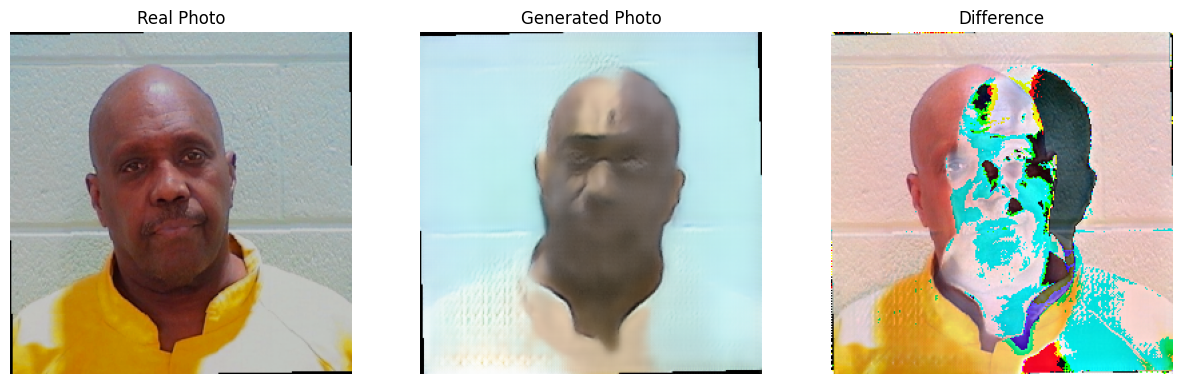

Generating visualization for image 2: /content/drive/MyDrive/CUFS_best/eval/eval_2_A01054.jpg
Saved visualization: /content/drive/MyDrive/CUFS_best/eval/eval_2_A01054.jpg


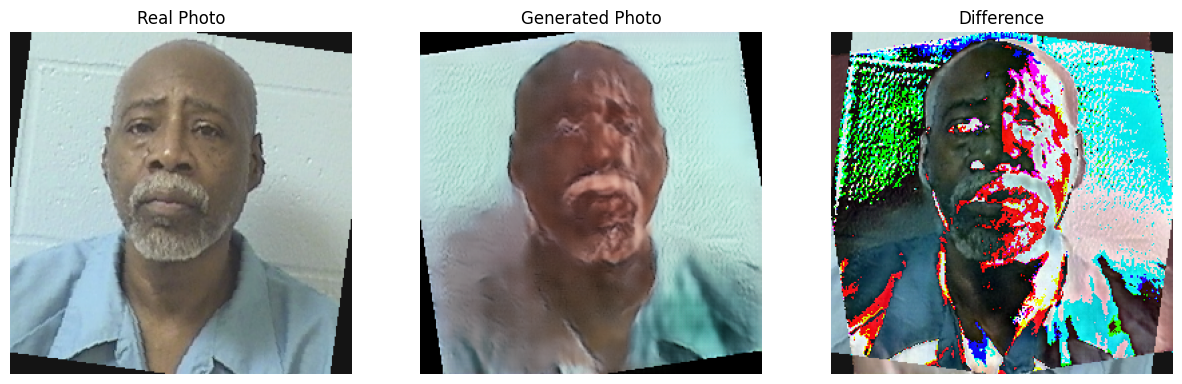

Generating visualization for image 3: /content/drive/MyDrive/CUFS_best/eval/eval_3_A01072.jpg
Saved visualization: /content/drive/MyDrive/CUFS_best/eval/eval_3_A01072.jpg


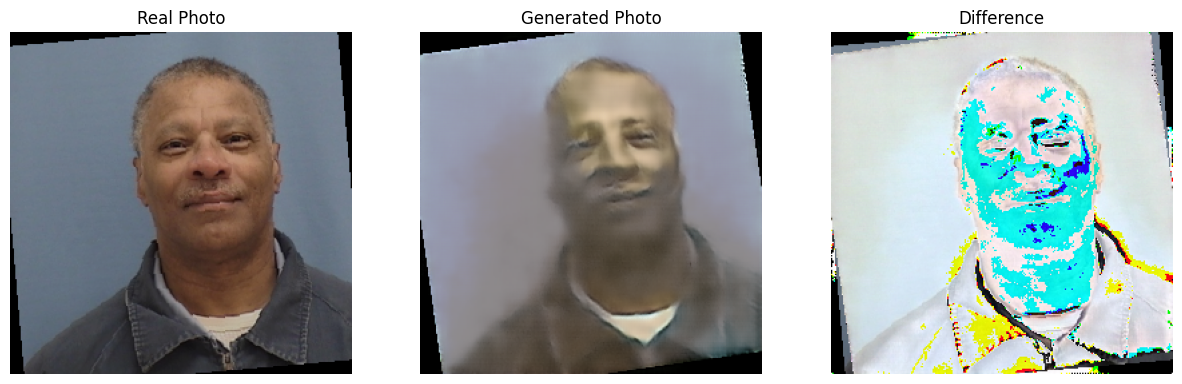

Generating visualization for image 4: /content/drive/MyDrive/CUFS_best/eval/eval_4_A01157.jpg
Saved visualization: /content/drive/MyDrive/CUFS_best/eval/eval_4_A01157.jpg


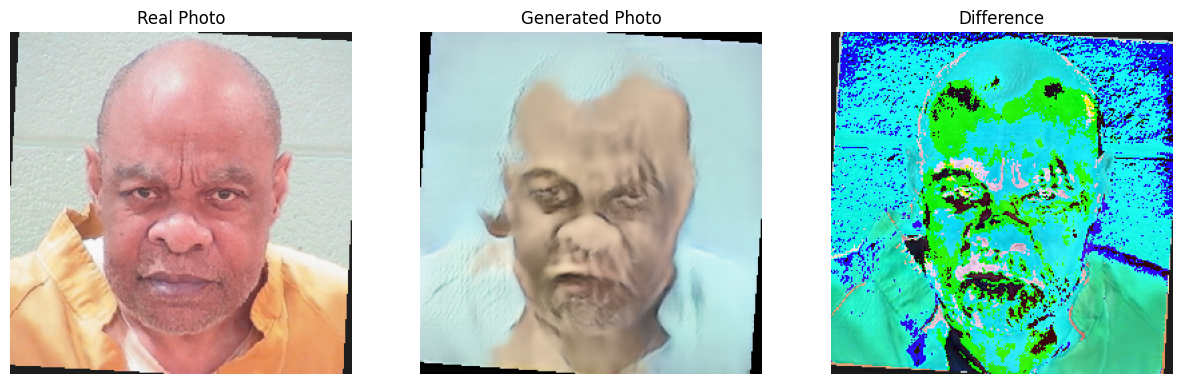

Generating visualization for image 5: /content/drive/MyDrive/CUFS_best/eval/eval_5_A01237.jpg
Saved visualization: /content/drive/MyDrive/CUFS_best/eval/eval_5_A01237.jpg


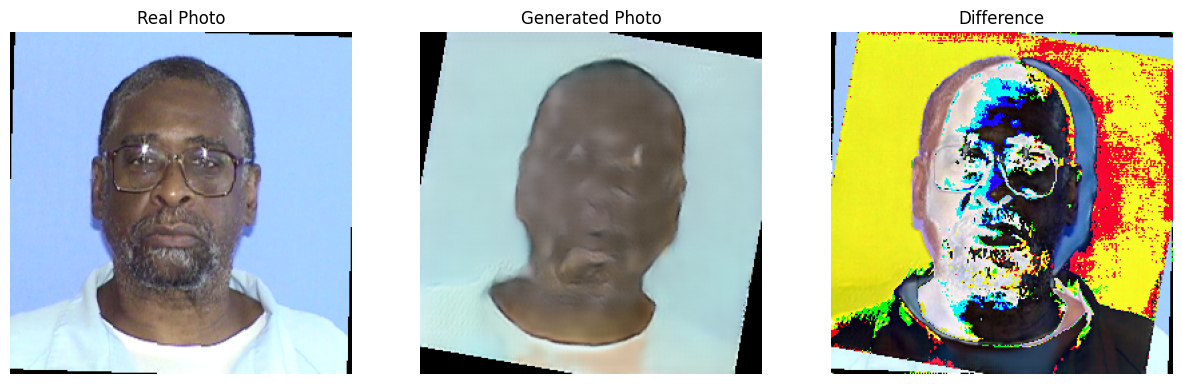


Evaluation Metrics:
SSIM: 0.5250
PSNR: 13.3043
MAE: 0.1625
Evaluation complete. Metrics and visualizations saved.


In [39]:
import os
import matplotlib.pyplot as plt
import numpy as np
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

# Ensure evaluation directory exists
eval_dir = '/content/drive/MyDrive/CUFS_best/eval'
os.makedirs(eval_dir, exist_ok=True)

# Evaluation function
def evaluate_model(generator, test_loader, device):
    generator.eval()
    ssim_scores = []
    psnr_scores = []
    mae_scores = []
    images_processed = 0  # Track number of images visualized

    with torch.no_grad():
        for i, (sketches, photos, filenames) in enumerate(test_loader):
            sketches = sketches.to(device)
            photos = photos.to(device)
            fake_photos = generator(sketches)

            # Denormalize
            fake_photos_np = fake_photos * 0.5 + 0.5
            photos_np = photos * 0.5 + 0.5
            fake_photos_np = fake_photos_np.cpu().permute(0, 2, 3, 1).numpy()
            photos_np = photos_np.cpu().permute(0, 2, 3, 1).numpy()
            fake_photos_uint8 = (fake_photos_np * 255).astype(np.uint8)
            photos_uint8 = (photos_np * 255).astype(np.uint8)

            for j in range(fake_photos_uint8.shape[0]):
                ssim_score = ssim(photos_uint8[j], fake_photos_uint8[j], channel_axis=2, data_range=255)
                psnr_score = psnr(photos_uint8[j], fake_photos_uint8[j], data_range=255)
                mae_score = np.mean(np.abs(photos_np[j] - fake_photos_np[j]))
                ssim_scores.append(ssim_score)
                psnr_scores.append(psnr_score)
                mae_scores.append(mae_score)

                # Visualize first 5 images across batches
                if images_processed < 5:
                    # Sanitize filename to avoid invalid characters
                    sanitized_filename = ''.join(c for c in filenames[j] if c.isalnum() or c in ('.', '_'))
                    save_path = f'{eval_dir}/eval_{images_processed+1}_{sanitized_filename}'

                    print(f"Generating visualization for image {images_processed+1}: {save_path}")

                    plt.figure(figsize=(15, 5))
                    plt.subplot(1, 3, 1)
                    plt.imshow(photos_uint8[j])
                    plt.title('Real Photo')
                    plt.axis('off')
                    plt.subplot(1, 3, 2)
                    plt.imshow(fake_photos_uint8[j])
                    plt.title('Generated Photo')
                    plt.axis('off')
                    plt.subplot(1, 3, 3)
                    plt.imshow(np.abs(photos_uint8[j] - fake_photos_uint8[j]), cmap='gray')
                    plt.title('Difference')
                    plt.axis('off')
                    try:
                        plt.savefig(save_path, bbox_inches='tight')
                        print(f"Saved visualization: {save_path}")
                    except Exception as e:
                        print(f"Failed to save visualization {save_path}: {e}")
                    plt.show()

                    images_processed += 1

            # Stop after processing 5 images
            if images_processed >= 5:
                break

    if images_processed < 5:
        print(f"Warning: Only {images_processed} images were visualized (test dataset may have fewer than 5 images).")

    metrics = {
        'SSIM': np.mean(ssim_scores) if ssim_scores else 0.0,
        'PSNR': np.mean(psnr_scores) if psnr_scores else 0.0,
        'MAE': np.mean(mae_scores) if mae_scores else 0.0
    }
    return metrics

# Evaluate model
metrics = evaluate_model(G_sketch_to_photo, test_dataloader, device)
print("\nEvaluation Metrics:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

# Save metrics to file
with open('/content/drive/MyDrive/CUFS_best/evaluation_metrics.txt', 'w') as f:
    for metric, value in metrics.items():
        f.write(f"{metric}: {value:.4f}\n")

print("Evaluation complete. Metrics and visualizations saved.")

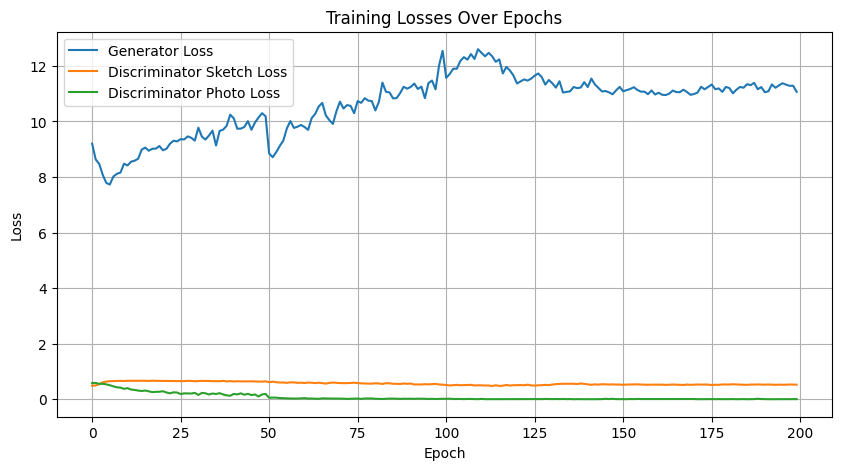


Evaluation Metrics:
SSIM: 0.4810
PSNR: 13.5123
MAE: 0.1520
Evaluation complete. Metrics and visualizations saved.


In [36]:

# Create directory for evaluation visualizations
eval_dir = '/content/drive/MyDrive/CUFS_best/eval'
os.makedirs(eval_dir, exist_ok=True)

# Plot training losses
plt.figure(figsize=(10, 5))
plt.plot(losses_g, label='Generator Loss')
plt.plot(losses_d_sketch, label='Discriminator Sketch Loss')
plt.plot(losses_d_photo, label='Discriminator Photo Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Losses Over Epochs')
plt.legend()
plt.grid(True)
plt.savefig('/content/drive/MyDrive/CUFS_best/training_losses.png')
plt.show()

# Evaluation function
def evaluate_model(generator, test_loader, device):
    generator.eval()
    ssim_scores = []
    psnr_scores = []
    mae_scores = []

    with torch.no_grad():
        for i, (sketches, photos, filenames) in enumerate(test_loader):
            sketches = sketches.to(device)
            photos = photos.to(device)
            fake_photos = generator(sketches)

            # Denormalize
            fake_photos_np = fake_photos * 0.5 + 0.5
            photos_np = photos * 0.5 + 0.5
            fake_photos_np = fake_photos_np.cpu().permute(0, 2, 3, 1).numpy()
            photos_np = photos_np.cpu().permute(0, 2, 3, 1).numpy()
            fake_photos_uint8 = (fake_photos_np * 255).astype(np.uint8)
            photos_uint8 = (photos_np * 255).astype(np.uint8)

            for j in range(fake_photos_uint8.shape[0]):
                ssim_score = ssim(photos_uint8[j], fake_photos_uint8[j], channel_axis=2, data_range=255)
                psnr_score = psnr(photos_uint8[j], fake_photos_uint8[j], data_range=255)
                mae_score = np.mean(np.abs(photos_np[j] - fake_photos_np[j]))
                ssim_scores.append(ssim_score)
                psnr_scores.append(psnr_score)
                mae_scores.append(mae_score)

                # Visualize first 5 images
                if j < 5:
                    plt.figure(figsize=(15, 5))
                    plt.subplot(1, 3, 1)
                    plt.imshow(photos_uint8[j])
                    plt.title('Real Photo')
                    plt.axis('off')
                    plt.subplot(1, 3, 2)
                    plt.imshow(fake_photos_uint8[j])
                    plt.title('Generated Photo')
                    plt.axis('off')
                    plt.subplot(1, 3, 3)
                    plt.imshow(np.abs(photos_uint8[j] - fake_photos_uint8[j]), cmap='gray')
                    plt.title('Difference')
                    plt.axis('off')
                    plt.savefig(f'{eval_dir}/eval_{filenames[j]}')
                    plt.close()

    metrics = {
        'SSIM': np.mean(ssim_scores),
        'PSNR': np.mean(psnr_scores),
        'MAE': np.mean(mae_scores)
    }
    return metrics

# Evaluate model
metrics = evaluate_model(G_sketch_to_photo, test_dataloader, device)
print("\nEvaluation Metrics:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

# Save metrics to file
with open('/content/drive/MyDrive/CUFS_best/evaluation_metrics.txt', 'w') as f:
    for metric, value in metrics.items():
        f.write(f"{metric}: {value:.4f}\n")

print("Evaluation complete. Metrics and visualizations saved.")


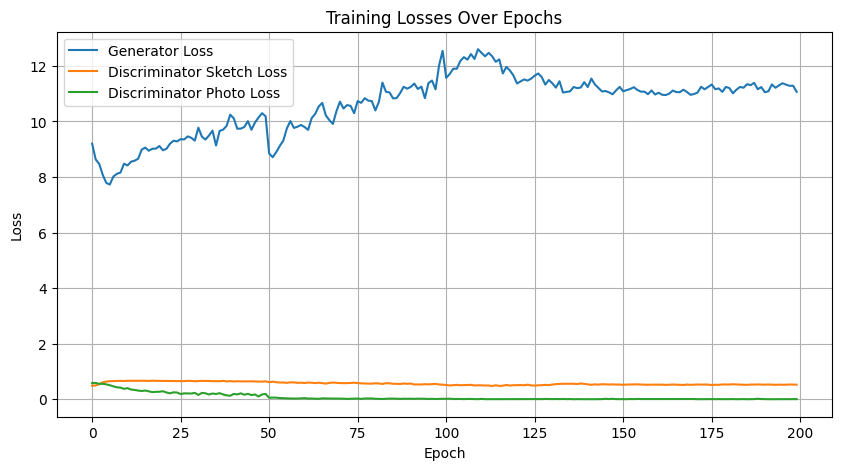


Evaluation Metrics:
SSIM: 0.4845
PSNR: 13.5429
MAE: 0.1513
Evaluation complete. Metrics and visualizations saved.


In [37]:
# Plot training losses
plt.figure(figsize=(10, 5))
plt.plot(losses_g, label='Generator Loss')
plt.plot(losses_d_sketch, label='Discriminator Sketch Loss')
plt.plot(losses_d_photo, label='Discriminator Photo Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Losses Over Epochs')
plt.legend()
plt.grid(True)
plt.savefig('/content/drive/MyDrive/CUFS_best/training_losses.png')
plt.show()

# Evaluation function
def evaluate_model(generator, test_loader, device):
    generator.eval()
    ssim_scores = []
    psnr_scores = []
    mae_scores = []

    with torch.no_grad():
        for i, (sketches, photos, filenames) in enumerate(test_loader):
            sketches = sketches.to(device)
            photos = photos.to(device)
            fake_photos = generator(sketches)

            # Denormalize
            fake_photos_np = fake_photos * 0.5 + 0.5
            photos_np = photos * 0.5 + 0.5
            fake_photos_np = fake_photos_np.cpu().permute(0, 2, 3, 1).numpy()
            photos_np = photos_np.cpu().permute(0, 2, 3, 1).numpy()
            fake_photos_uint8 = (fake_photos_np * 255).astype(np.uint8)
            photos_uint8 = (photos_np * 255).astype(np.uint8)

            for j in range(fake_photos_uint8.shape[0]):
                ssim_score = ssim(photos_uint8[j], fake_photos_uint8[j], channel_axis=2, data_range=255)
                psnr_score = psnr(photos_uint8[j], fake_photos_uint8[j], data_range=255)
                mae_score = np.mean(np.abs(photos_np[j] - fake_photos_np[j]))
                ssim_scores.append(ssim_score)
                psnr_scores.append(psnr_score)
                mae_scores.append(mae_score)

                # Visualize first 5 images
                if i < 5:
                    plt.figure(figsize=(15, 5))
                    plt.subplot(1, 3, 1)
                    plt.imshow(photos_uint8[j])
                    plt.title('Real Photo')
                    plt.axis('off')
                    plt.subplot(1, 3, 2)
                    plt.imshow(fake_photos_uint8[j])
                    plt.title('Generated Photo')
                    plt.axis('off')
                    plt.subplot(1, 3, 3)
                    plt.imshow(np.abs(photos_uint8[j] - fake_photos_uint8[j]), cmap='gray')
                    plt.title('Difference')
                    plt.axis('off')
                    plt.savefig(f'/content/drive/MyDrive/CUFS_best/eval_{filenames[j]}.png')
                    plt.close()

    metrics = {
        'SSIM': np.mean(ssim_scores),
        'PSNR': np.mean(psnr_scores),
        'MAE': np.mean(mae_scores)
    }
    return metrics

# Evaluate model
metrics = evaluate_model(G_sketch_to_photo, test_dataloader, device)
print("\nEvaluation Metrics:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

# Save metrics to file
with open('/content/drive/MyDrive/CUFS_best/evaluation_metrics.txt', 'w') as f:
    for metric, value in metrics.items():
        f.write(f"{metric}: {value:.4f}\n")

print("Evaluation complete. Metrics and visualizations saved.")

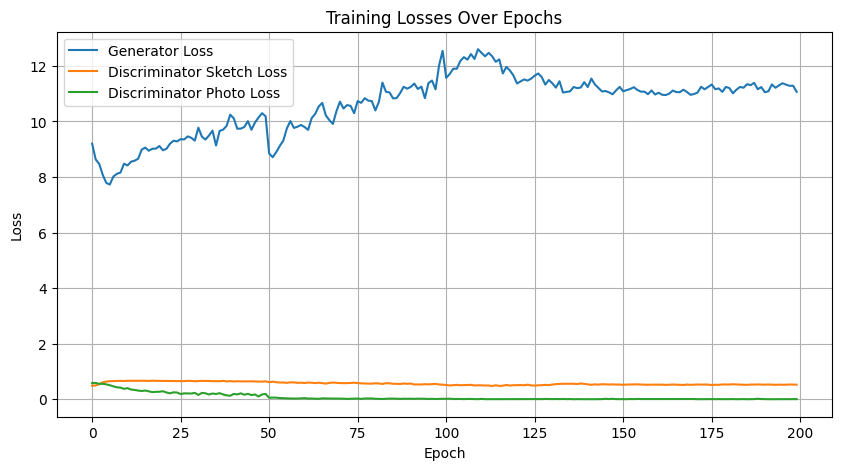

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/CUFS_best/eval/eval_A00367.jpg.png'

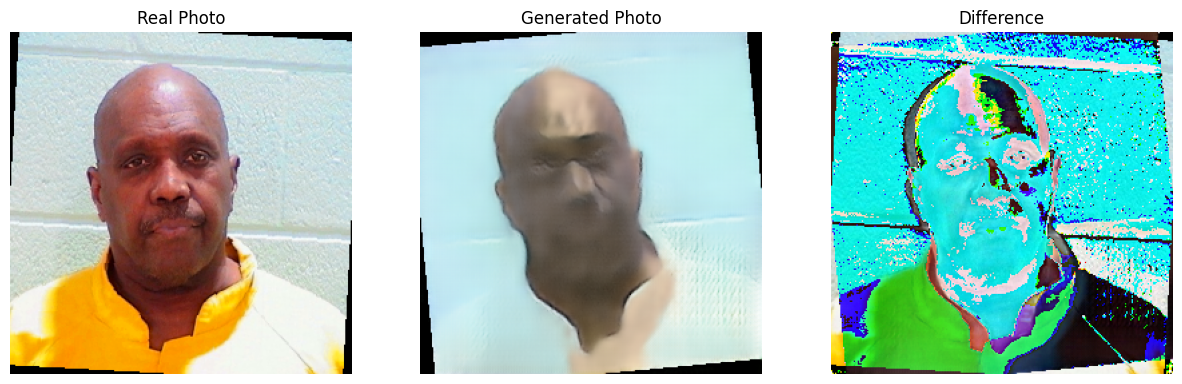

In [35]:
# Plot training losses
plt.figure(figsize=(10, 5))
plt.plot(losses_g, label='Generator Loss')
plt.plot(losses_d_sketch, label='Discriminator Sketch Loss')
plt.plot(losses_d_photo, label='Discriminator Photo Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Losses Over Epochs')
plt.legend()
plt.grid(True)
plt.savefig('/content/drive/MyDrive/CUFS_best/training_losses.png')
plt.show()

# Evaluation function
def evaluate_model(generator, test_loader, device):
    generator.eval()
    ssim_scores = []
    psnr_scores = []
    mae_scores = []

    with torch.no_grad():
        for i, (sketches, photos, filenames) in enumerate(test_loader):
            sketches = sketches.to(device)
            photos = photos.to(device)
            fake_photos = generator(sketches)

            # Denormalize
            fake_photos_np = fake_photos * 0.5 + 0.5
            photos_np = photos * 0.5 + 0.5
            fake_photos_np = fake_photos_np.cpu().permute(0, 2, 3, 1).numpy()
            photos_np = photos_np.cpu().permute(0, 2, 3, 1).numpy()
            fake_photos_uint8 = (fake_photos_np * 255).astype(np.uint8)
            photos_uint8 = (photos_np * 255).astype(np.uint8)

            for j in range(fake_photos_uint8.shape[0]):
                ssim_score = ssim(photos_uint8[j], fake_photos_uint8[j], channel_axis=2, data_range=255)
                psnr_score = psnr(photos_uint8[j], fake_photos_uint8[j], data_range=255)
                mae_score = np.mean(np.abs(photos_np[j] - fake_photos_np[j]))
                ssim_scores.append(ssim_score)
                psnr_scores.append(psnr_score)
                mae_scores.append(mae_score)

                # Visualize first 5 images
                if i < 5:
                    plt.figure(figsize=(15, 5))
                    plt.subplot(1, 3, 1)
                    plt.imshow(photos_uint8[j])
                    plt.title('Real Photo')
                    plt.axis('off')
                    plt.subplot(1, 3, 2)
                    plt.imshow(fake_photos_uint8[j])
                    plt.title('Generated Photo')
                    plt.axis('off')
                    plt.subplot(1, 3, 3)
                    plt.imshow(np.abs(photos_uint8[j] - fake_photos_uint8[j]), cmap='gray')
                    plt.title('Difference')
                    plt.axis('off')
                    plt.savefig(f'/content/drive/MyDrive/CUFS_best/eval/eval_{filenames[j]}.png')
                    plt.close()

    metrics = {
        'SSIM': np.mean(ssim_scores),
        'PSNR': np.mean(psnr_scores),
        'MAE': np.mean(mae_scores)
    }
    return metrics

# Evaluate model
metrics = evaluate_model(G_sketch_to_photo, test_dataloader, device)
print("\nEvaluation Metrics:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

# Save metrics to file
with open('/content/drive/MyDrive/CUFS_best/evaluation_metrics.txt', 'w') as f:
    for metric, value in metrics.items():
        f.write(f"{metric}: {value:.4f}\n")

print("Evaluation complete. Metrics and visualizations saved.")